In [1]:
import torch

from torch.nn import Sequential, RNN, Flatten

from dataset import EarthSystemsDataset 

## Reccurent Neural Network (RNN)

In [12]:
def rnn_sequence1(in_size, label_size):
    # in_size is number of variables
    layers = [
        RNN(in_size, in_size*2, batch_first=True, num_layers=2),
        # RNN(in_size*2, in_size*3, batch_first=True),
        # Flatten(),
        

        
    ]
    return Sequential(*layers)

r = rnn_sequence1(4, 1)
a = torch.randn(40, 15, 4)

r(a)[0].shape

torch.Size([40, 15, 8])

In [10]:
data_var_names = ['global_temp', 'elec_fossil', 'elec_clean', 'co2', 'ch4']
y_vals = ['temp_change']
lags = 15

data = EarthSystemsDataset(data_var_names, y_vals=y_vals, val_frac=0.1, lags=lags, mode='rnn')

In [ ]:
data[0][0].shape

In [2]:
a = torch.randn(40, 15, 4)
# (batch_size, lags, num vars)
a.flatten(start_dim=1).shape

torch.Size([40, 60])

In [1]:
from data import grab_dataset

<AxesSubplot:>

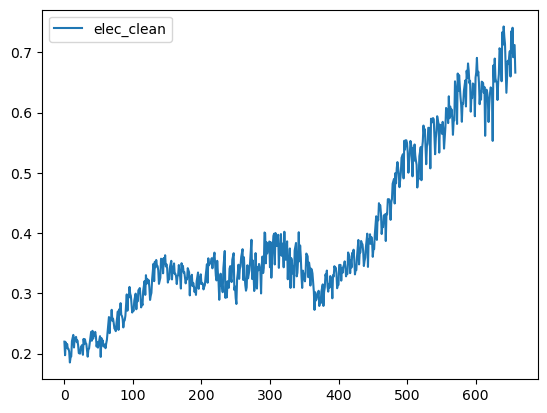

In [4]:
a = grab_dataset('elec_clean')
a.plot(kind='line', y='elec_clean')

<AxesSubplot:>

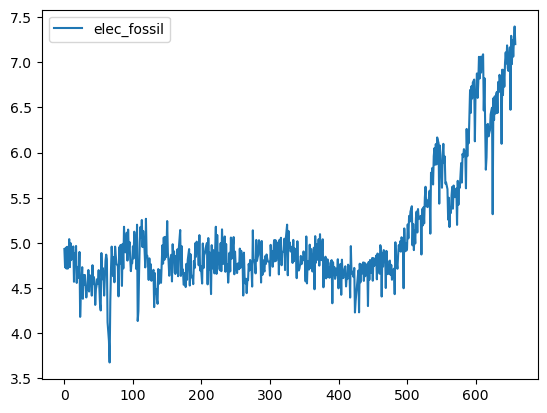

In [5]:
b = grab_dataset('elec_fossil')
b.plot(kind='line', y='elec_fossil')